In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
import cv2
import time
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import gamma


class CSO:

    def __init__(self, fitness, P=5, n=2, pa=0.25, beta=5, bound=None,
                plot=False, min=True, verbose=False, Tmax=10):


        self.fitness = fitness
        self.P = P
        self.n = n
        self.Tmax = Tmax
        self.pa = pa
        self.beta = beta
        self.bound = bound
        self.plot = plot
        self.min = min
        self.verbose = verbose

        # X = (U-L)*rand + L (U AND L ARE UPPER AND LOWER BOUND OF X)
        # U AND L VARY BASED ON THE DIFFERENT DIMENSION OF X

        self.X = []

        if bound is not None:
            for (U, L) in bound:
                x = (U-L)*np.random.rand(P,) + L
                self.X.append(x)
            self.X = np.array(self.X).T
        else:
            self.X = np.random.randn(P,n)

    def update_position_1(self):


        num = gamma(1+self.beta)*np.sin(np.pi*self.beta/2)
        den = gamma((1+self.beta)/2)*self.beta*(2**((self.beta-1)/2))
        σu = (num/den)**(1/self.beta)
        σv = 1
        u = np.random.normal(0, σu, self.n)
        v = np.random.normal(0, σv, self.n)
        S = u/(np.abs(v)**(1/self.beta))

        # DEFINING GLOBAL BEST SOLUTION BASED ON FITNESS VALUE

        for i in range(self.P):
            if i==0:
                self.best = self.X[i,:].copy()
                self.res = self.fitness(self.best)
            else:
                self.best,self.res = self.optimum(self.best, self.X[i,:])

        # Xnew = self.X.copy()
        # for i in range(self.P):
        #     Xnew[i,:] += np.random.randn(self.n)*0.01*S*(Xnew[i,:]-self.best)
        #     self.X[i,:] = self.optimum(Xnew[i,:], self.X[i,:])


    def update_position_2(self):


        Xnew = self.X.copy()
        Xold = self.X.copy()
        for i in range(self.P):
            d1,d2 = np.random.randint(0,5,2)
            for j in range(self.n):
                r = np.random.rand()
                if r < self.pa:
                    Xnew[i,j] += np.random.rand()*(Xold[d1,j]-Xold[d2,j])
            self.X[i,:],_ = self.optimum(Xnew[i,:], self.X[i,:])

    def optimum(self, best, particle_x):

        if self.min:
            curr = self.fitness(particle_x)
            if self.res > curr:
                best = particle_x.copy()
                self.res = curr
        else:
            curr = self.fitness(particle_x)
            if self.res < curr:
                best = particle_x.copy()
                self.res = curr
        return best,curr

    def clip_X(self):

        # IF BOUND IS SPECIFIED THEN CLIP 'X' VALUES SO THAT THEY ARE IN THE SPECIFIED RANGE

        if self.bound is not None:
            for i in range(self.n):
                xmin, xmax = self.bound[i]
                self.X[:,i] = np.clip(self.X[:,i], xmin, xmax)

    def execute(self):


        self.fitness_time, self.time = [], []

        self.optimum_res = None
        self.optimum_best = None


        for t in range(self.Tmax):
            self.update_position_1()
            self.clip_X()
            self.update_position_2()
            self.clip_X()
            self.fitness_time.append(self.res)
            self.time.append(t)
            if self.verbose:
                print('Iteration:  ',t,'| best local fitness (cost):',round(self.res,7))

            if self.optimum_res == None:
              self.optimum_res = self.res
              self.optimum_best = self.best
            elif self.min:
              if self.optimum_res > self.res:
                self.optium_res = self.res
                self.optimum_best = self.best
            elif self.min == False:
              if self.optimum_res < self.res:
                self.optium_res = self.res
                self.optimum_best = self.best



        print('\nOPTIMUM SOLUTION\n  >', np.round(self.optimum_best.reshape(-1),7).tolist())
        print('\nOPTIMUM FITNESS\n  >', np.round(self.optimum_res,7))
        print()
        if self.plot:
            self.Fplot()

    def Fplot(self):

        # PLOTS GLOBAL FITNESS (OR COST) VALUE VS ITERATION GRAPH

        plt.plot(self.time, self.fitness_time)
        plt.title('Fitness value vs Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Fitness value')
        plt.show()


In [ ]:
video_features = np.load("/content/drive/MyDrive/video_features.npy",allow_pickle=True)
audio_features = np.load("/content/drive/MyDrive/audio_features_updated.npy",allow_pickle=True)
labels = np.load("/content/drive/MyDrive/labels.npy",allow_pickle=True)

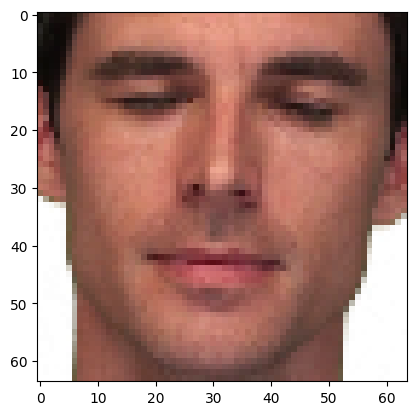

In [ ]:
for i in range(len(video_features)):
  for k in range(6):
    video_features[i][k] = cv2.cvtColor(video_features[i][k], cv2.COLOR_BGR2RGB)
plt.imshow(video_features[0][0])

In [ ]:
print(audio_features.shape)
print(video_features.shape)
print(labels.shape)

(1440, 181)
(1440, 6, 64, 64, 3)
(1440, 8)


In [ ]:
video_features_train,video_features_test,audio_features_train,audio_features_test,labels_train,labels_test = train_test_split(video_features,audio_features,labels,test_size=0.2,random_state=101)
video_features_test,video_features_val,audio_features_test,audio_features_val,labels_test,labels_val = train_test_split(video_features_test,audio_features_test,labels_test,test_size=0.5,random_state=101)

In [ ]:
print(video_features_train.shape)
print(video_features_val.shape)
print(video_features_test.shape)
print(audio_features_train.shape)
print(audio_features_val.shape)
print(audio_features_test.shape)
print(labels_train.shape)
print(labels_val.shape)
print(labels_test.shape)

(1152, 6, 64, 64, 3)
(144, 6, 64, 64, 3)
(144, 6, 64, 64, 3)
(1152, 181)
(144, 181)
(144, 181)
(1152, 8)
(144, 8)
(144, 8)


In [ ]:
# Define the input layers for video and audio
input_video = Input(shape=(6, 64, 64, 3))
input_audio = Input(shape=(181, 1))

In [ ]:
#Define layer Structure of the model
def layer_structure():
    # Define the video processing layers
    conv = ConvLSTM2D(64, 3, activation='gelu', padding='same')(input_video)
    conv = Convolution2D(64, 3, activation='gelu', padding='same')(conv)
    pool = MaxPooling2D((2, 2), strides=(2, 2))(conv)
    conv = Convolution2D(128, 3, activation='gelu', padding='same')(pool)
    pool = MaxPooling2D((2, 2), strides=(2, 2))(conv)
    conv = Convolution2D(128, 3, activation='gelu', padding='same')(pool)
    pool = MaxPooling2D((2, 2), strides=(2, 2))(conv)
    conv = Convolution2D(256, 3, activation='gelu', padding='same')(pool)
    conv = Convolution2D(256, 3, activation='gelu', padding='same')(pool)
    conv = Convolution2D(256, 3, activation='gelu', padding='same')(pool)
    pool = MaxPooling2D((2, 2), strides=(2, 2))(conv)
    conv = Convolution2D(512, 3, activation='gelu', padding='same')(pool)
    conv = Convolution2D(512, 3, activation='gelu', padding='same')(pool)
    conv = Convolution2D(512, 3, activation='gelu', padding='same')(pool)
    pool = MaxPooling2D((2, 2), strides=(2, 2))(conv)
    output_video = Flatten()(pool)

    # Define the audio processing layers with dropout and batch normalization
    conv = Convolution1D(64, 10, activation='gelu')(input_audio)
    conv = Convolution1D(128, 10, activation='gelu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(conv)
    pool = MaxPooling1D(8)(conv)
    drop = Dropout(0.4)(pool)
    bn = BatchNormalization()(drop)
    output_audio = Flatten()(bn)

    # Concatenate of video and audio features
    concatenate = keras.layers.Concatenate()([output_video, output_audio])

    # Final fully connected layers
    final_layer = Dense(128, activation='gelu')(concatenate)
    prediction_layer = Dense(8, activation='softmax')(final_layer)
    model = Model(inputs=[input_video, input_audio], outputs=[prediction_layer])

    return model

In [ ]:
# Optimizer
def optimize(model, LEARNING_RATE):
    opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    # Compile the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model, early_stopping

In [ ]:
import random
acc = -1

random.seed(0)
def fitness(X):
    global acc
    EPOCHS = int(X[0])
    BATCH_SIZE = int(X[1])
    LEARNING_RATE = X[2]

    print("EPOCHS: ", EPOCHS)
    print("BATCH_SIZE: ", BATCH_SIZE)
    print("LEARNING_RATE: ", LEARNING_RATE)

    model = None
    model = layer_structure()
    model, early_stopping = optimize(model, LEARNING_RATE)

    #training
    start = time.time()
    history = model.fit([video_features_train, audio_features_train], labels_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=([video_features_val, audio_features_val], labels_val),
                        callbacks=[early_stopping])
    end = time.time()
    train_time_avg = (end - start) / 50

    start=time.time()
    score=model.evaluate([video_features_test,audio_features_test],labels_test)
    end=time.time()
    test_time=end-start
    print("Test loss of the model is - " , score[0])
    print("Test accuracy of the model is - " , score[1]*100 , "%")

    if score[1]*100 > acc:
        acc = score[1]*100
        model.save("fusion_batch_normalisation_with_CSO.h5")

    return score[1]*100

CSO(fitness=fitness, bound=[(80,100), (32,64), (0.001, 0.005)], n = 3, verbose = True, min = False).execute()


EPOCHS:  96
BATCH_SIZE:  42
LEARNING_RATE:  0.003911635292154655
Epoch 1/96
28/28 [==============================] - 36s 594ms/step - loss: 57.2235 - accuracy: 0.1884 - val_loss: 2.6433 - val_accuracy: 0.2361
Epoch 2/96
28/28 [==============================] - 15s 530ms/step - loss: 2.4955 - accuracy: 0.2830 - val_loss: 2.5207 - val_accuracy: 0.2569
Epoch 3/96
28/28 [==============================] - 15s 530ms/step - loss: 2.0950 - accuracy: 0.3229 - val_loss: 2.3113 - val_accuracy: 0.2222
Epoch 4/96
28/28 [==============================] - 15s 534ms/step - loss: 1.9746 - accuracy: 0.3854 - val_loss: 1.9410 - val_accuracy: 0.3333
Epoch 5/96
28/28 [==============================] - 15s 531ms/step - loss: 1.8166 - accuracy: 0.4184 - val_loss: 1.9675 - val_accuracy: 0.3750
Epoch 6/96
28/28 [==============================] - 15s 533ms/step - loss: 1.8471 - accuracy: 0.4280 - val_loss: 2.1372 - val_accuracy: 0.3403
Epoch 7/96
28/28 [==============================] - 15s 533ms/step - loss: 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/90
32/32 [==============================] - 23s 481ms/step - loss: 135.8426 - accuracy: 0.1866 - val_loss: 3.1599 - val_accuracy: 0.2222
Epoch 2/90
32/32 [==============================] - 15s 461ms/step - loss: 2.4187 - accuracy: 0.3021 - val_loss: 2.1990 - val_accuracy: 0.3403
Epoch 3/90
32/32 [==============================] - 15s 461ms/step - loss: 2.4728 - accuracy: 0.2977 - val_loss: 2.2396 - val_accuracy: 0.3403
Epoch 4/90
32/32 [==============================] - 15s 461ms/step - loss: 1.9962 - accuracy: 0.3446 - val_loss: 1.9937 - val_accuracy: 0.3542
Epoch 5/90
32/32 [==============================] - 15s 459ms/step - loss: 1.8884 - accuracy: 0.3741 - val_loss: 2.1154 - val_accuracy: 0.2431
Epoch 6/90
32/32 [==============================] - 15s 459ms/step - loss: 1.8795 - accuracy: 0.3715 - val_loss: 2.1794 - val_accuracy: 0.3333
Epoch 7/90
32/32 [==============================] - 15s 460ms/step - loss: 1.7978 - accuracy: 0.4097 - val_loss: 2.0149 - val_accuracy: 0.37